<a href="https://colab.research.google.com/github/akhiltabjula/ComputationalMethodsForInformationSystems/blob/master/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install spacy
!pip install pyLDAvis

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
import pandas as pd
df = pd.read_csv("/content/titles.csv")
df["Title"].head()

0                               Data science in action
1    Data science and its relationship to big data ...
2    Data Science for Business: What you need to kn...
3                          Data science and prediction
4    Data science, predictive analytics, and big da...
Name: Title, dtype: object

In [ ]:
df["Title"]=df["Title"].str.lower()
# Convert to list
data = df["Title"].values.tolist()

#remove end spacings
data = [re.sub(" $","",sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:5])

['data science in action', 'data science and its relationship to big data and data-driven decision making', 'data science for business: what you need to know about data mining and data-analytic thinking', 'data science and prediction', 'data science, predictive analytics, and big data: a revolution that will transform supply chain design and management']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:5])

[['data', 'science', 'in', 'action'], ['data', 'science', 'and', 'its', 'relationship', 'to', 'big', 'data', 'and', 'data', 'driven', 'decision', 'making'], ['data', 'science', 'for', 'business', 'what', 'you', 'need', 'to', 'know', 'about', 'data', 'mining', 'and', 'data', 'analytic', 'thinking'], ['data', 'science', 'and', 'prediction'], ['data', 'science', 'predictive', 'analytics', 'and', 'big', 'data', 'revolution', 'that', 'will', 'transform', 'supply', 'chain', 'design', 'and', 'management']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['data', 'science', 'in', 'action']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['datum', 'science', 'action']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [ ]:
res = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=20,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.071*"science" + 0.071*"data" + 0.036*"list" + 0.036*"pass" + 0.036*"evil" '
  '+ 0.036*"wise" + 0.036*"miss" + 0.036*"cluster" + 0.036*"message" + '
  '0.036*"deletion"'),
 (1,
  '0.089*"science" + 0.046*"correlated" + 0.046*"color" + 0.046*"citation" + '
  '0.046*"new" + 0.046*"topic" + 0.046*"infrastructure" + 0.046*"model" + '
  '0.002*"benefit" + 0.002*"storage"'),
 (2,
  '0.144*"datum" + 0.034*"management" + 0.034*"network" + 0.017*"impact" + '
  '0.017*"supply" + 0.017*"transform" + 0.017*"citation" + 0.017*"count" + '
  '0.017*"faculty" + 0.017*"revolution"'),
 (3,
  '0.065*"data" + 0.065*"structure" + 0.044*"protein" + 0.044*"datum" + '
  '0.044*"fair" + 0.023*"science" + 0.022*"interaction" + 0.022*"cloud" + '
  '0.022*"predict" + 0.022*"network"'),
 (4,
  '0.175*"science" + 0.033*"biomaterial" + 0.033*"method" + '
  '0.033*"introduction" + 0.033*"integrative" + 0.033*"person" + '
  '0.033*"education" + 0.033*"qualitative" + 0.033*"perspective" + '
  '0.033*"informat

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.488077987007932

Coherence Score:  0.5101519145002923


In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))



[(10,
  [('analytic', 0.20833333333333334),
   ('citizen', 0.08333333333333333),
   ('climate', 0.08333333333333333),
   ('algorithm', 0.08333333333333333),
   ('sixth', 0.041666666666666664),
   ('projection', 0.041666666666666664),
   ('neural', 0.041666666666666664),
   ('comprehensive', 0.041666666666666664),
   ('predictive', 0.041666666666666664),
   ('business', 0.041666666666666664)]),
 (1,
  [('research', 0.18518518518518517),
   ('practice', 0.07407407407407407),
   ('endf', 0.07407407407407407),
   ('monitoring', 0.037037037037037035),
   ('unrealized', 0.037037037037037035),
   ('potential', 0.037037037037037035),
   ('analysis', 0.037037037037037035),
   ('biodiversity', 0.037037037037037035),
   ('miss', 0.037037037037037035),
   ('grid', 0.037037037037037035)]),
 (18,
  [('science', 0.44),
   ('structure', 0.16),
   ('fisherie', 0.04),
   ('cloud', 0.04),
   ('pipeline', 0.04),
   ('increasingly', 0.04),
   ('challenge', 0.04),
   ('miss', 0.04),
   ('covariance', 0.04),

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.759461562081104


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values_lda = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)

In [ ]:
for m, cv in zip(x, coherence_values_lda):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6946
Num Topics = 8  has Coherence Value of 0.7618
Num Topics = 14  has Coherence Value of 0.7716
Num Topics = 20  has Coherence Value of 0.7687
Num Topics = 26  has Coherence Value of 0.7555
Num Topics = 32  has Coherence Value of 0.7491
Num Topics = 38  has Coherence Value of 0.7269


**Here the coherence score is increasing for every topic. Hence the model is realtively acceptable**

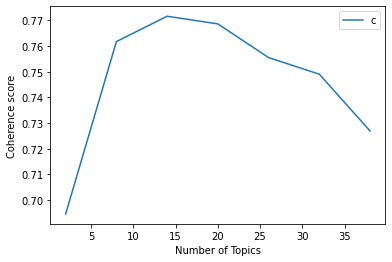

In [ ]:
plt.plot(x, coherence_values_lda)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.222*"datum" + 0.111*"construct" + 0.111*"monitoring" + 0.111*"business" + '
  '0.111*"application" + 0.111*"color" + 0.111*"big" + 0.111*"discovery" + '
  '0.000*"cipre" + 0.000*"holographic"'),
 (16,
  '0.455*"science" + 0.091*"global" + 0.045*"history" + 0.045*"potential" + '
  '0.045*"section" + 0.045*"biomaterial" + 0.045*"correlated" + '
  '0.045*"integrative" + 0.045*"idea" + 0.045*"free"'),
 (21,
  '0.273*"model" + 0.182*"information" + 0.091*"literacy" + 0.091*"study" + '
  '0.091*"signaling" + 0.091*"processing" + 0.091*"run" + 0.091*"cluster" + '
  '0.000*"summarize" + 0.000*"trap"'),
 (24,
  '0.467*"science" + 0.067*"hirise" + 0.067*"technology" + 0.067*"machine" + '
  '0.067*"implication" + 0.067*"discovery" + 0.067*"practice" + 0.067*"dawn" + '
  '0.067*"problem" + 0.000*"holographic"'),
 (7,
  '0.188*"structure" + 0.125*"big" + 0.062*"evaluate" + 0.062*"omega" + '
  '0.062*"thinking" + 0.062*"guide" + 0.062*"qualitative" + 0.062*"neural" + '
  '0.062*"link" + 0

**Summarised topics from resultant modeling**
1.   Scientific researches indicae that role of citizens in transforming ang imputing the world is very important.
2.   Increasing age and career will result in increase in productivity of a person and define them if they are fisherie ot incomplete.
.
.
13.  In corporates, changing management will impact fabricating consumers and products.

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
number_of_topics = 7

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model 
    return dictionary,doc_term_matrix

In [ ]:
from gensim.models import LsiModel
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
dictionary,doc_term_matrix=prepare_corpus(data_lemmatized)
model_list_lsa, coherence_values_lsa = compute_coherence_values(dictionary, doc_term_matrix,data_lemmatized,40,2,6)

In [ ]:
coherence_values_lsa

[0.3668808313449678,
 0.3668808313449678,
 0.4456881620549651,
 0.3668808313449678,
 0.4456881620549651,
 0.3668808313449678,
 0.3668808313449678]

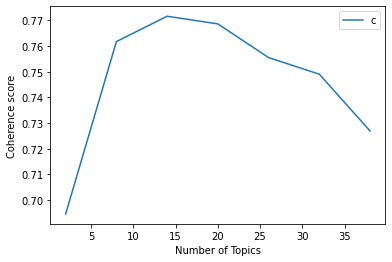

In [ ]:
plt.plot(x, coherence_values_lsa)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Write your code here
for m, cv in zip(x, coherence_values_lsa):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3669
Num Topics = 8  has Coherence Value of 0.3669
Num Topics = 14  has Coherence Value of 0.4457
Num Topics = 20  has Coherence Value of 0.3669
Num Topics = 26  has Coherence Value of 0.4457
Num Topics = 32  has Coherence Value of 0.3669
Num Topics = 38  has Coherence Value of 0.3669


In [ ]:
# Select the model and print the topics
optimal_model_lsa = model_list_lsa[5]
model_topics_lsa = optimal_model_lsa.show_topics(formatted=False)
pprint(optimal_model_lsa.print_topics(num_words=10))

[(0,
  '0.755*"datum" + 0.562*"science" + 0.106*"mining" + 0.096*"big" + '
  '0.082*"analytic" + 0.063*"knowledge" + 0.055*"relationship" + 0.054*"data" '
  '+ 0.053*"management" + 0.050*"business"'),
 (1,
  '0.744*"science" + -0.538*"datum" + -0.128*"big" + 0.085*"research" + '
  '0.079*"change" + -0.077*"protein" + -0.069*"analytic" + -0.069*"mining" + '
  '0.053*"scientific" + 0.052*"citizen"'),
 (2,
  '0.622*"data" + 0.372*"nuclear" + 0.234*"vii" + 0.234*"endf" + '
  '0.234*"technology" + 0.158*"structure" + 0.144*"product" + 0.139*"next" + '
  '0.138*"evaluate" + 0.138*"generation"'),
 (3,
  '-0.388*"data" + -0.378*"big" + -0.276*"analytic" + -0.245*"new" + '
  '0.232*"nuclear" + 0.178*"endf" + 0.178*"technology" + 0.178*"vii" + '
  '0.174*"protein" + -0.125*"structure"'),
 (4,
  '-0.293*"protein" + -0.292*"data" + 0.274*"big" + -0.263*"network" + '
  '0.245*"analytic" + 0.242*"new" + 0.220*"nuclear" + -0.186*"fair" + '
  '0.161*"endf" + 0.161*"vii"'),
 (5,
  '-0.341*"research" + 

In [ ]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(data_lemmatized,number_of_topics,words)
pprint(model)

[(0, '0.755*"datum" + 0.562*"science" + 0.106*"mining" + 0.096*"big" + 0.082*"analytic" + 0.063*"knowledge" + 0.055*"relationship" + 0.054*"data" + 0.053*"management" + 0.050*"business"'), (1, '0.744*"science" + -0.538*"datum" + -0.128*"big" + 0.085*"research" + 0.079*"change" + -0.077*"protein" + -0.069*"analytic" + -0.069*"mining" + 0.053*"scientific" + 0.052*"citizen"'), (2, '-0.622*"data" + -0.372*"nuclear" + -0.234*"endf" + -0.234*"technology" + -0.234*"vii" + -0.158*"structure" + -0.144*"product" + -0.139*"next" + -0.138*"evaluate" + -0.138*"generation"'), (3, '0.388*"data" + 0.378*"big" + 0.276*"analytic" + 0.245*"new" + -0.232*"nuclear" + -0.178*"endf" + -0.178*"technology" + -0.178*"vii" + -0.174*"protein" + 0.125*"structure"'), (4, '0.293*"protein" + 0.292*"data" + -0.274*"big" + 0.263*"network" + -0.245*"analytic" + -0.242*"new" + -0.220*"nuclear" + 0.186*"fair" + -0.161*"vii" + -0.161*"technology"'), (5, '0.341*"research" + -0.329*"fair" + 0.283*"protein" + 0.261*"global" +

**Summarised topics from resultant modeling**

1.   Impelementing big data and data sceinece in any corporates will result in productive growth of business.
2.   Using Data science in health care sector, scientific research and develoment departments can imrove health conditions of citizens
3.   Controductory, combining data science with AI and nuclear messiles, might relust in erradication of genatrations.
4.    Practical implementation of data science, AI and ML in health care and dietary fields can relate to increase muscular growth of generations.
5. Data analytics and big data combining will result in change of technological implementations of IOT devices.
6. Researches from different data analytical sources state that global carbon foot print is responsible of every citizen.
7. Global network transformation can be done only with technological advancements.




## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)


**LDA - Latent Dirichlet Allocation:**

Latent Dirichlet Allocation (LDA) is a “generative probabilistic model” of a collection of composites made up of parts. Its uses include Natural Language Processing (NLP) and topic modelling, among others. In terms of topic modelling, the composites are documents and the parts are words and/or phrases (phrases n words in length are referred to as n-grams).

**LSA - Latent semantic analysis**

Latent Semantic Analysis (LSA) is a theory and method for extracting and representing the contextual-usage meaning of words by statistical computations applied to a large corpus of text. LSA is an information retrieval technique which analyzes and identifies the pattern in unstructured collection of text and the relationship between them.
LSA itself is an unsupervised way of uncovering synonyms in a collection of documents.

From our results, we can interpret that LDA has coherence value of 72.69% while LSA has 36.69%. Higher the coherence, better is the algorithm.